In [120]:
import requests
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine 
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from nltk.stem import WordNetLemmatizer
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
#stop_words = set(stopwords.words('english'))
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import spacy
import pickle

import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.wrappers import Incremental
from dask_ml.metrics import accuracy_score

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# OBJECTIVE

From the previous analysis we found that 

1. The dataset contains features that are not necessary to solve our **multi-classification problem**. 

2. For this **text classification problem**, we are going to build another dataframe that contains ‘Descriptor’ and ‘Compalint Type’



# PIPELINE

1. Text Classifiction problems can be modelled well with Linear SVC, Naive Bayers, Random Forests

2. Modelling the Prediction of Compalint based on Descriptor

In [121]:
df = dd.read_csv("C:\\EZOIC_ASSESSMENT\\Brooklyn.csv",error_bad_lines=False)
df = df.compute()

In [122]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

def to_lower(x):
    return x.lower()


from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavani.nrusimhadevar\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavani.nrusimhadevar\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
df["Resolution Description"]= df["Resolution Description"].astype(str)
df["Descriptor"]= df["Descriptor"].astype(str) 

df['Descriptor'] = df['Descriptor'].apply(to_lower)
df["Descriptor"]= df["Descriptor"].astype(str) 
df['Descriptor'] = df['Descriptor'].apply(remove_stop_words)
df['Descriptor'] = df['Descriptor'].apply(remove_digits)
df['Descriptor'] = df['Descriptor'].apply(remove_punctuation)
df['Descriptor']= df['Descriptor'].apply(porter.stem)
df['Resolution Description'] = df['Resolution Description'].apply(to_lower)
df['Resolution Description'] = df['Resolution Description'].apply(remove_stop_words)
df['Resolution Description'] = df['Resolution Description'].apply(remove_digits)
df['Resolution Description'] = df['Resolution Description'].apply(remove_punctuation)
df['Resolution Description']= df['Resolution Description'].apply(porter.stem)

In [124]:
df['Location Type'] = df['Location Type'].astype(str) 
df['Location Type'] = df['Location Type'].apply(to_lower)
df['Location Type'] = df['Location Type'].apply(remove_punctuation)

In [125]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,27842668,2014-04-14 12:35:00,2014-04-15 09:35:00,DEP,Department of Environmental Protection,Water System,dirty water w,nan,11210,1707 ALBANY AVENUE,...,Unspecified,BROOKLYN,40.631376,-73.936905,"(40.63137607740962, -73.93690514641224)",0.0,0.0,2014,4,0
1,27842678,2014-04-14 18:48:00,2014-04-14 18:55:00,DEP,Department of Environmental Protection,Water System,hydrant running wc,nan,11226,398 PARKSIDE AVENUE,...,Unspecified,BROOKLYN,40.655759,-73.957915,"(40.65575937956233, -73.957915385467)",0.0,0.0,2014,4,0
2,27842679,2014-04-14 13:21:00,2014-04-14 13:22:00,DEP,Department of Environmental Protection,Water System,hydrant running wc,nan,11226,24 PARKSIDE AVENUE,...,Unspecified,BROOKLYN,40.651769,-73.969825,"(40.651769462936095, -73.96982500664355)",0.0,0.0,2014,4,0
3,27842681,2014-04-14 12:32:00,2014-04-14 12:33:00,DEP,Department of Environmental Protection,Water System,leak use comments wa,nan,11214,2107 79 STREET,...,Unspecified,BROOKLYN,40.606984,-73.991504,"(40.606983639606455, -73.9915042331188)",0.0,0.0,2014,4,0
4,27842684,2014-04-14 00:00:00,2014-05-19 00:00:00,DOHMH,Department of Health and Mental Hygiene,Rodent,rat sight,other explain below,11217,STATE STREET,...,Unspecified,BROOKLYN,40.685576,-73.979275,"(40.68557622732326, -73.97927459764733)",35.0,35.0,2014,4,0


In [126]:
df= df[df['Longitude'].notnull()]
df= df[df['Latitude'].notnull()]
df= df[df['Location'].notnull()]
df['Complaint Type'] = df['Complaint Type'].apply(remove_punctuation)
df['Complaint Type'] = df['Complaint Type'].apply(to_lower)
df[['Complaint Type','Descriptor','Resolution Description']].head()

,Complaint Type,Descriptor,Resolution Description
0,water system,dirty water w,department environmental protection resolved c...
1,water system,hydrant running wc,department environmental protection determined...
2,water system,hydrant running wc,department environmental protection determined...
3,water system,leak use comments wa,department environmental protection determined...
4,rodent,rat sight,department health mental hygiene review compla...


#### Target Variable Rephrasing

In [127]:
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("heat") ]["Complaint Type"].unique(),'HeatComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("noise") ]["Complaint Type"].unique(), 'NoiseComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("construction|plumbing") ]["Complaint Type"].unique(),'Construction/PlumbingComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("dof") ]["Complaint Type"].unique(),'DOFComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("parking|blocked driveway|park") ]["Complaint Type"].unique(),'ParkingComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("paint") ]["Complaint Type"].unique(),'Paint/PlasterComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("water") ]["Complaint Type"].unique(),'WaterComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("dirt|sanitation condition") ]["Complaint Type"].unique(),'SanitationComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("highway") ]["Complaint Type"].unique(),'HighwayComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['street light condition', 'street condition',
       'street sign  damaged', 'sidewalk condition', 'dead tree',
       'street sign  dangling', 'street sign  missing', 'damaged tree',
       'new tree request', 'illegal tree damage',
       'rootsewersidewalk condition', 'overgrown treebranches',
       'request xmas tree collection', 'deaddying tree',
       'dep sidewalk condition','graffiti','derelict vehicles',
       'for hire vehicle complaint', 'derelict vehicle',
       'for hire vehicle report', 'abandoned vehicle',
       'city vehicle placard complaint'],'StreetComplaints')

df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("sewer|sewage") ]["Complaint Type"].unique(),'SewerComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("homeless") ]["Complaint Type"].unique(),'HomelessComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['traffic signal condition', 'traffic'],'TrafficComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['taxi complaint', 'taxi report', 'taxi compliment',
       'green taxi report', 'dispatched taxi complaint'],'TaxiComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['doorwindow', 'flooringstairs', 'buildinguse', 'outside building',
       'vacant apartment', 'building marshals office',
       'building condition','elevator'],'BuildingComplaints')
pd.set_option('display.max_rows', None)
df['Complaint Type'].value_counts()
df.loc[~df["Complaint Type"].isin(['NoiseComplaints',
'HeatComplaints',                           
'StreetComplaints',                         
'Construction/PlumbingComplaints',                    
'SanitationComplaints',                     
'WaterComplaints',                         
'BuildingComplaints',                       
'Paint/PlasterComplaints',                   
'TaxiComplaints',                           
'HomelessComplaints',
'DOFComplaints',
'HighwayComplaints',
'ParkingComplaints',
'broken muni meter',                        
'rodent',                                   
'consumer complaint',                      
'electric',                                  
'general',                                 
'SewerComplaints',                          
'request large bulky item collection',      
'air quality',                                
'nonconst',                                 
'TrafficComplaints',                         
'vending',                                   
'food establishment',                       
'missed collection all materials' ]), "Complaint Type"] = "Other Complaints"

In [128]:
df['Complaint Type'] = df['Complaint Type'].replace(['vending'],'StreetComplaints')
df['Complaint Type'].value_counts()

NoiseComplaints                        988432
StreetComplaints                       862840
ParkingComplaints                      695212
HeatComplaints                         566484
Other Complaints                       507239
Construction/PlumbingComplaints        444245
WaterComplaints                        259741
BuildingComplaints                     224772
SanitationComplaints                   218853
Paint/PlasterComplaints                204010
request large bulky item collection    118902
TrafficComplaints                      110124
SewerComplaints                        100244
electric                                96992
missed collection all materials         85276
rodent                                  83383
nonconst                                65550
general                                 47744
consumer complaint                      44268
broken muni meter                       30243
TaxiComplaints                          21525
air quality                       

#### Location Type Rephrasing

In [129]:
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("residential") ]["Location Type"].unique(),'RESIDENTIAL')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("school") ]["Location Type"].unique(),'SCHOOL')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("apartment") ]["Location Type"].unique(),'APARTMENT')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("comercial|commercial") ]["Location Type"].unique(),'COMMERCIAL')
df['Location Type'] = df['Location Type'].replace(['public gardenpark', 'park', 'parkplayground', 'public parkgarden'],'PARK')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("restaurant") ]["Location Type"].unique(),'RESTAURANT')


In [130]:
df['Location Type'].value_counts()

RESIDENTIAL                           2272841
nan                                   1147298
streetsidewalk                         957818
street                                 568278
sidewalk                               493383
COMMERCIAL                              87448
RESTAURANT                              75333
3 family apt building                   36911
mixed use                               27892
lot                                     27551
PARK                                    25933
12 family dwelling                      25730
APARTMENT                               13320
other explain below                     12207
highway                                  6060
3 family mixed use building              6055
curb                                     5349
SCHOOL                                   4814
streetcurbside                           4794
other                                    4364
house of worship                         4364
vacant lot                        

#### Status

In [131]:
df.loc[((df['Status']!='Closed') & (df['Year'] == 2012) 
       & (df['Resolution Description'].str.contains("investigated|submitted|reviewed|inspected"))) , "Status"] = "Closed"

In [132]:
df.loc[((df['Status']!='Closed' ) 
       & (df['Descriptor'].str.contains("derelict vehicl") ) 
       & (df['Resolution Description'].str.contains("removed"))) , "Status"] = "Closed"

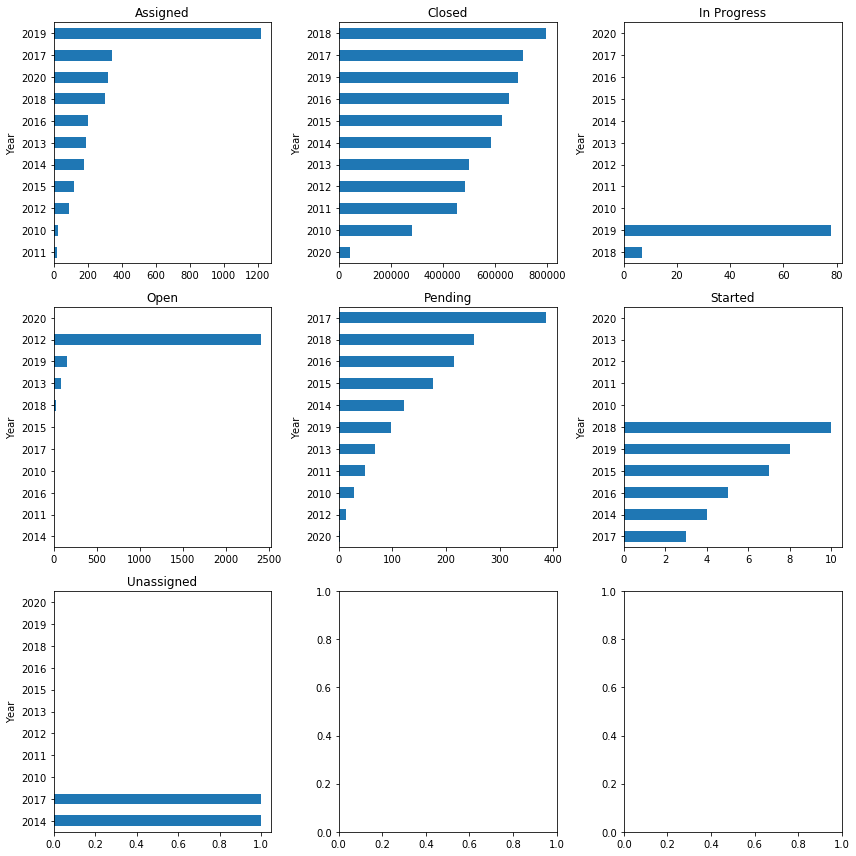

In [133]:
borough_comp = df.groupby(['Year','Status']).size().unstack()

col_number = 3
row_number = 3
fig, axes = plt.subplots(row_number,col_number, figsize=(12,12))

for i, (label,col) in enumerate(borough_comp.iteritems()):
    ax = axes[int(i/col_number), i%col_number]
    col = col.sort_values(ascending=True)[:15]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
    
plt.tight_layout()

In [134]:
df = df[df['Location Type']!='nan']
df = df[df['Resolution Description']!='nan']

In [135]:
df.head(2).T

,4,8
Unique Key,27842684,27842706
Created Date,2014-04-14 00:00:00,2014-04-14 00:00:00
Closed Date,2014-05-19 00:00:00,2014-04-18 00:00:00
Agency,DOHMH,DOHMH
Agency Name,Department of Health and Mental Hygiene,Department of Health and Mental Hygiene
Complaint Type,rodent,rodent
Descriptor,rat sight,rat sight
Location Type,other explain below,12 family dwelling
Incident Zip,11217,11226
Incident Address,STATE STREET,2409 BEVERLY ROAD


In [136]:
df1 = df[['Agency','Location Type','Complaint Type','Descriptor','Resolution_Time','Total_Time','Year','Month','DayofWeek','Status','Resolution Description']]

In [137]:
df1.shape

(4565208, 11)

In [138]:
df_model = df1.head(65000)

In [139]:
#df_model = df1

In [140]:
df_model.head()

,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description
4,DOHMH,other explain below,rodent,rat sight,35.0,35.0,2014,4,0,Closed,department health mental hygiene review compla...
8,DOHMH,12 family dwelling,rodent,rat sight,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...
9,DOHMH,3 family mixed use building,rodent,rat sight,18.0,18.0,2014,4,0,Closed,department health mental hygiene review compla...
18,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item
20,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item


#########################################################################################################################
#########################################################################################################################
#########################################################################################################################

### Create a new column 'complaint_id' with encoded Complaint Types

In [141]:
df_model['complaint_id'] = df_model['Complaint Type'].factorize()[0]
complaint_id_df = df_model[['Complaint Type', 'complaint_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(complaint_id_df.values)
id_to_category = dict(complaint_id_df[['complaint_id', 'Complaint Type']].values)

# New dataframe
df_model.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description,complaint_id
4,DOHMH,other explain below,rodent,rat sight,35.0,35.0,2014,4,0,Closed,department health mental hygiene review compla...,0
8,DOHMH,12 family dwelling,rodent,rat sight,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...,0
9,DOHMH,3 family mixed use building,rodent,rat sight,18.0,18.0,2014,4,0,Closed,department health mental hygiene review compla...,0
18,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item,1
20,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item,1


### Text Preprocessing

In [142]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [143]:
df_model.head()

,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description,complaint_id
4,DOHMH,other explain below,rodent,rat sight,35.0,35.0,2014,4,0,Closed,department health mental hygiene review compla...,0
8,DOHMH,12 family dwelling,rodent,rat sight,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...,0
9,DOHMH,3 family mixed use building,rodent,rat sight,18.0,18.0,2014,4,0,Closed,department health mental hygiene review compla...,0
18,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item,1
20,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item,1


**TF/IDF**

1. TERM FREQUENCY (TF)  = Number of times term appears in doc / Total number of words in doc

2. IDF = ln(no of docs / no of docs term appears in)

3. TF-IDF gives **word frequency** scores

4. ngrams(1,2) --> gives UNIGRAMS AND BIGRAMS

5. min_df: **remove the words** from the vocabulary which have occurred in less than ‘min_df’ number of files

As we knew descriptor is one of the important feature

### TFIDF on "Descriptor"

In [161]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_model['Descriptor']).toarray()

labels = df_model.complaint_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 65000 complaints is represented by 357 features (TF-IDF score of unigrams and bigrams)


#### Trying to Find most correlated terms of descriptor for each complaint type

In [145]:
 #Finding the three most correlated terms with each of the complaint categories
N = 3
for Product, complaint_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == complaint_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> BuildingComplaints:
  * Most Correlated Unigrams are: fram, door, floor
  * Most Correlated Bigrams are: window pan, door fram, window fram

==> Construction/PlumbingComplaints:
  * Most Correlated Unigrams are: toilet, bathtubshow, basinsink
  * Most Correlated Bigrams are: entire build, steam piperis, water suppli

==> HeatComplaints:
  * Most Correlated Unigrams are: entire, build, apart
  * Most Correlated Bigrams are: heavy flow, street conddumpoutdropoff, entire build

==> HighwayComplaints:
  * Most Correlated Unigrams are: rail, pothole, highway
  * Most Correlated Bigrams are: rail highway, guard rail, pothole highway

==> HomelessComplaints:
  * Most Correlated Unigrams are: ceil, pest, nan
  * Most Correlated Bigrams are: heavy flow, street conddumpoutdropoff, entire build

==> NoiseComplaints:
  * Most Correlated Unigrams are: bangingpound, musicparti, loud
  * Most Correlated Bigrams are: cartruck mus, loud talk, loud musicparti

==> Other Complaints:
  * Most Correla

############################################################################################

1. Multinominal Niave Bayes is most suitable for **word counts** where data are typically represented as word vector counts and  ignores non-occurrences of a feature i

2. Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed **conditioned independent** to each other (the classifiers), P(x|y) where x is the feature and y is the classifier

#############################################################################################

1. Linear SVC works well on text classification is a part of SVM best for multi class text classification

2. For larger datasts SVM is not a better option as compared to naive bayes it takes more time 

3. If classes are over lapping( not in the case of our exampels) it doesnt work well

 

In [158]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [147]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.996308,0.001179
MultinomialNB,0.995139,0.001000
RandomForestClassifier,0.688018,0.031381


#### Model Evaluation

In [162]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_model.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

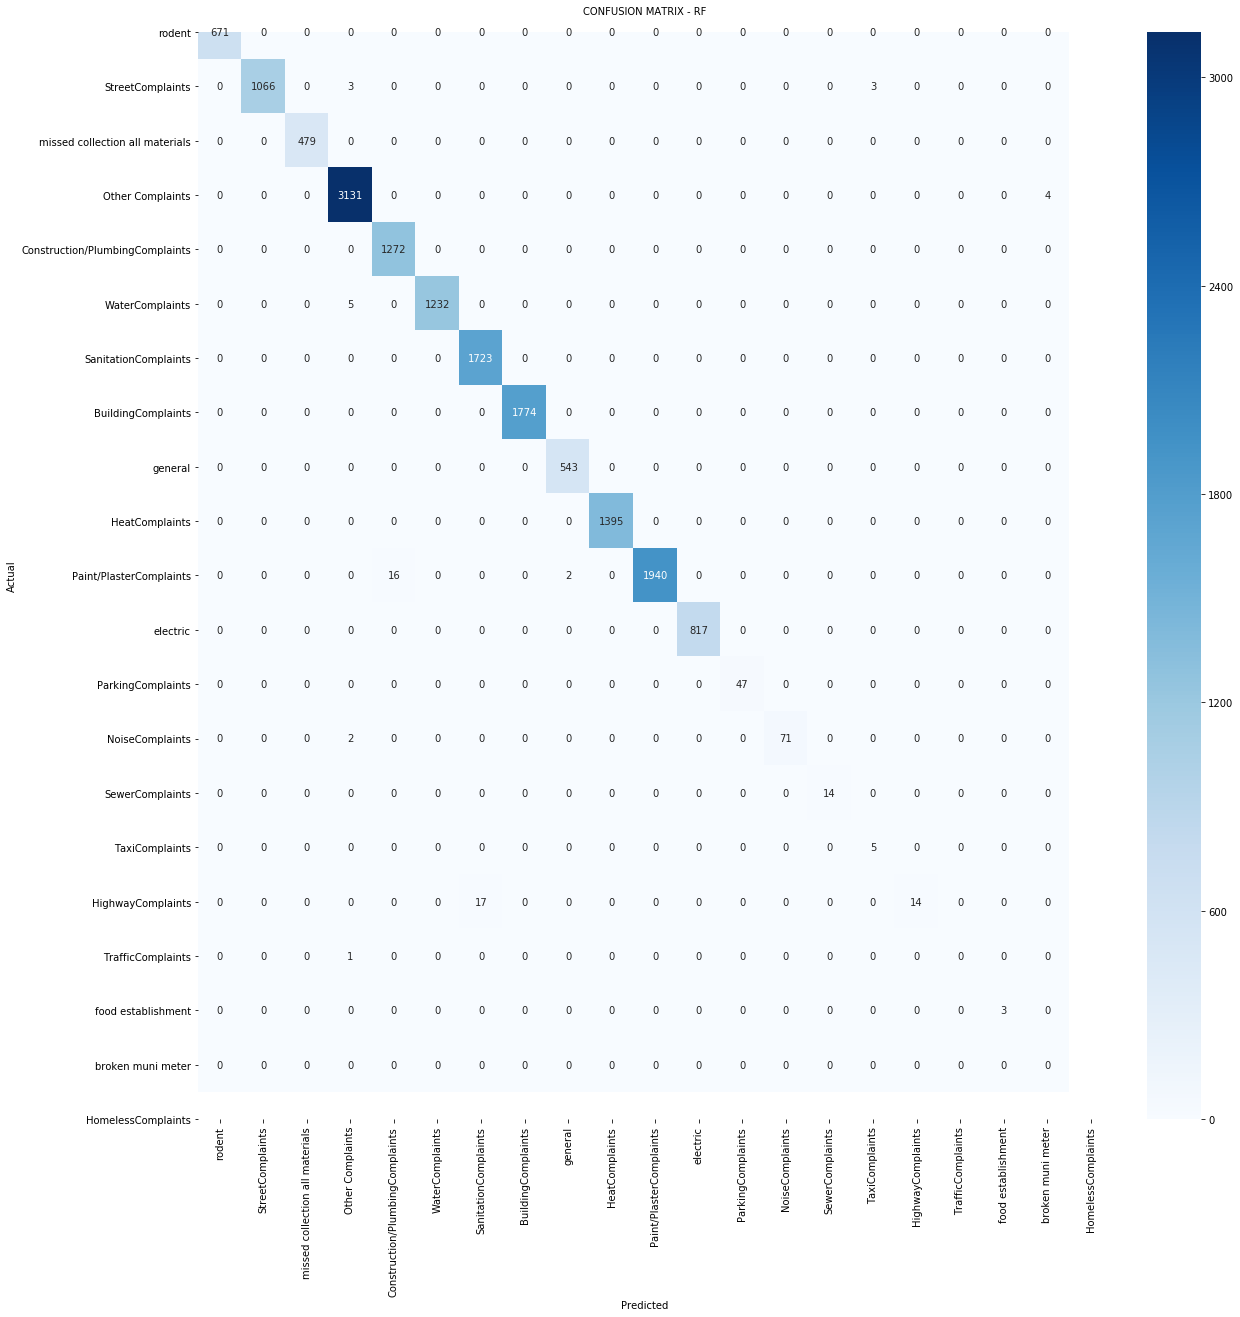

In [164]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=complaint_id_df['Complaint Type'].values, 
            yticklabels=complaint_id_df['Complaint Type'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - RF\n", size=10);

### Seeing what complaints are classified different

#### Most correlated terms in each compalint

In [166]:
model.fit(features, labels)

N = 4
for Product, complaint_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[complaint_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(Product))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'BuildingComplaints':
  * Top unigrams: door, floor, stair, roof
  * Top bigrams: window pan, door dumbwait, window fram, roof doorhatch

==> 'Construction/PlumbingComplaints':
  * Top unigrams: basinsink, bathtubshow, toilet, sewer
  * Top bigrams: water suppli, steam piperis, basket request, puddle roof

==> 'HeatComplaints':
  * Top unigrams: apart, entire, build, limb
  * Top bigrams: entire build, basket request, limb fallen, branch limb

==> 'HighwayComplaints':
  * Top unigrams: highway, litter, pothole, rail
  * Top bigrams: pothole highway, rail highway, guard rail, dead anim

==> 'HomelessComplaints':
  * Top unigrams: nan, posted, company, service
  * Top bigrams: basket request, puddle roof, ea litter, basket improper

==> 'NoiseComplaints':
  * Top unigrams: bangingpound, loud, cartruck, mus
  * Top bigrams: cartruck mus, loud talk, truck nois, collection truck

==> 'Other Complaints':
  * Top unigrams: detector, pigeon, animal, pest
  * Top bigrams: smoke detector, b

### Predictions

In [150]:
X = df_model['Descriptor']
y = df_model['Complaint Type']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

##### I am predicting my model for new descriptors

In [152]:
new_descriptor1 = """loud music from neighbours"""
print(model.predict(fitted_vectorizer.transform([new_descriptor1])))

['NoiseComplaints']


In [153]:
new_descriptor2 = """rodent in kitchen"""
print(model.predict(fitted_vectorizer.transform([new_descriptor2])))

['Other Complaints']


In [154]:
new_descriptor3 = """dirty roads"""
print(model.predict(fitted_vectorizer.transform([new_descriptor3])))

['SanitationComplaints']


##### TF IDF Vectorization

cv = CountVectorizer(min_df=10)
X_agency = cv.fit_transform(df_model['Agency'])
print(X_agency)

##### Apply TFIDF to "resolution description", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df_model['Resolution Description'])

tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_descriptor = tv.fit_transform(df_model['Descriptor'])

lb = LabelBinarizer(sparse_output=True)
X_status = lb.fit_transform(df_model['Status'])

lb = LabelBinarizer(sparse_output=True)
X_comtype = lb.fit_transform(df_model['Complaint Type'])

lb = LabelBinarizer(sparse_output=True)
X_loctype = lb.fit_transform(df_model['Location Type'])

##### Create our final sparse matrix
X_dummies = csr_matrix(pd.get_dummies(df_model[['Total_Time', 'Resolution_Time','Year','Month','DayofWeek']], sparse=True).values)

###### Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_descriptor, X_status, X_loctype)).tocsr()

print("nrows",sparse_merge.shape[0])